---
## <b>1 <span style='color:#3f4d63'>I</span> Introduction</b>
---

### **Competition's Goal**

The goal of this competition is to assess the language proficiency of 8th-12th grade English Language Learners (ELLs). Utilizing a dataset of essays written by ELLs will help to develop proficiency models that better supports all students.

Your work will help ELLs receive more accurate feedback on their language development and expedite the grading cycle for teachers. These outcomes could enable ELLs to receive more appropriate learning tasks that will help them improve their English language proficiency.

![](https://www.caracteristicas.co/wp-content/uploads/2017/05/textos-literarios-1-e1569197016482.jpg)

### **Data Description**

The dataset presented here (the ELLIPSE corpus) comprises argumentative essays written by 8th-12th grade English Language Learners (ELLs). The essays have been scored according to six analytic measures: cohesion, syntax, vocabulary, phraseology, grammar, and conventions.

Each measure represents a component of proficiency in essay writing, with greater scores corresponding to greater proficiency in that measure. The scores range from 1.0 to 5.0 in increments of 0.5. Your task is to predict the score of each of the six measures for the essays given in the test set.

#### **Importing packages ⬇️**

In [ ]:
from IPython.display import clear_output, display_html
import os
import warnings
from pathlib import Path

# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
from scipy import stats

# Train Test Split
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, learning_curve, train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

warnings.filterwarnings('ignore')

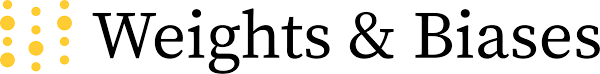

### **Weights and Biases ⬇️**

You will need a unique API key to log in to Weights & Biases.

* If you don't have a Weights & Biases account, you can go to [https://wandb.ai/site](https://wandb.ai/site) and create a FREE account. Access your API key: [https://wandb.ai/authorize](https://wandb.ai/authorize).

There are two ways you can login using a Kaggle kernel:

* Run a cell with `wandb.login()`. It will ask for the API key, which you can `copy` + `paste` in.
* You can also use Kaggle secrets to store your API key and use the code snippet below to login. Check out [this discussion post](https://www.kaggle.com/product-feedback/114053) to learn more about Kaggle secrets.

In [ ]:
!pip install wandb
clear_output()
import wandb
from wandb.keras import WandbCallback

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

---
## <b>2 <span style='color:#3f4d63'>I</span> Exploratory Data Analysis</b>
---

## **Basic Information**

To start with we're going to get a first insight from the data we're given. In order to do so, we'll implement two different functions: 

* The first one is going to load each of the datasets given. 
* The second one will give us some basic information about each dataset.

In [ ]:
def load_data():
    '''Load each of the datasets we are given.'''
    
    data_dir = Path("../input/feedback-prize-english-language-learning")
    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')
    return train, test, sample_submission

from termcolor import colored
def data_info(csv, name="Train"):
    '''Prints basic information about the datasets we are given.'''
    '''Inspired by: https://www.kaggle.com/code/andradaolteanu/rsna-fracture-detection-dicom-images-explore'''
    
    print(colored('==== {} ===='.format(name), 'blue', attrs=['bold']))
    print(colored('Shape: ', 'blue', attrs=['bold']), csv.shape)
    print(colored('NaN Values: ', 'blue', attrs=['bold']), csv.isnull().sum().sum(), '\n')
    #print(colored('Columns: ', 'blue', attrs=['bold']), list(csv.columns))
    
    display_html(csv.head())
    if name != 'Sample Submission': print("\n")

train, test, sample_submission = load_data()
clear_output()

names = ["Train", "Test", "Sample Submission"]
for i, df in enumerate([train, test, sample_submission]): 
    data_info(df, names[i])

* The essays are given a score for each of the seven analytic measures above: cohesion, etc. These analytic measures comprise the target for the competition. Therefore, let's analyse them a little bit.

In [ ]:
train.select_dtypes(['int','float']).describe().T.style.background_gradient(cmap='Blues')

In [ ]:
from scipy import stats

figure = plt.figure(figsize = (22,5))
for i, col in enumerate(train.select_dtypes(['int','float']).columns): 
    ax = plt.subplot(1, 6, i+1)
    if train[col].dtype == 'int': 
        sns.distplot(train[col], fit=stats.norm, color = 'red')        
    else: 
        sns.distplot(train[col], fit=stats.norm)        
    ax.set_ylim((0.0, 5.0))
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Distribution Plots', y=1.02)
plt.show()

* Essay example:

In [ ]:
train['full_text'][0]

* One thing that you may have noticed is that in the text there are some programming symbols like `\n`. Let's start by getting rid of them.

In [ ]:
import re

train['full_text'] = train["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
test['full_text'] = test["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

## Character Count

In [ ]:
train['ncharacters'] = train['full_text'].str.len()
avg_char = round(train['ncharacters'].mean())
max_char = round(train['ncharacters'].max())
print('Average length: {}'.format(avg_char))
print('Max length: {}'.format(max_char))

In [ ]:
plt.figure(figsize = (22,5))
sns.distplot(train['ncharacters'])
plt.axvline(x = avg_char, color = 'red')
plt.title('Character Count')

## Word Count

Let's look at the word count distribution across the dataset. The token count will inform settings for our model, like max sequence length and the types of model architectures we can use. Only some are suitable for very long sequences.

In [ ]:
train['nwords'] = train['full_text'].apply(lambda x: len(x.split()))
avg_words = round(train['nwords'].mean())
max_words = round(train['nwords'].max())
print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))

In [ ]:
plt.figure(figsize = (22,5))
sns.distplot(train['nwords'])
plt.axvline(x = avg_words, color = 'red')
plt.title('Word count')

In [ ]:
def plot_distribution_per_score(c): 
    scores = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
    figure, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (22,5))
    for i, col in enumerate(scores):
        conditionlist = [
        (train[col] >= 4.5) ,
        (train[col] >= 2) & (train[col] < 4.5),
        (train[col] < 2)]
        choicelist = ['High', 'Mid', 'Low']
        train['performance'] = np.select(conditionlist, choicelist, default='Not Specified')

        mask = train.performance != 'Mid'
        sns.kdeplot(train[mask][c], hue = train.performance, ax = axes[i])
        axes[i].set_title(col)

        mask_low = train.performance == 'Low'
        avg_low = train[mask_low][c].mean()
        axes[i].axvline(x = avg_low, color = 'green', linestyle = '--')

        mask_high = train.performance == 'High'
        avg_high = train[mask_high][c].mean()
        axes[i].axvline(x = avg_high, color = 'orange', linestyle = '--')

        del train['performance']

Let's observe how word count is distributed depending on scores. 

* Word count tend to be greater for those essays having great scores. Except for `grammar`, where both means are almost equal.

In [ ]:
plot_distribution_per_score('nwords')

## **Sentence Count and Average Length**

In [ ]:
from nltk.tokenize import sent_tokenize

train['sent_count'] = train['full_text'].apply(lambda x: len(sent_tokenize(x)))
avg_sent = round(train['sent_count'].mean())
print('Average Count: {}'.format(avg_sent))

train['avg_sent_len'] = train['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
avg_sent_len = round(np.mean(train['avg_sent_len']))
print('Average Sentence Length: {}'.format(avg_sent_len))

In [ ]:
plt.figure(figsize = (22,5))
for i, col in enumerate(['sent_count','avg_sent_len']):
        title = 'Sentence Count' if i == 0 else 'Average Sentence Length'
        mean = avg_sent if i == 0 else avg_sent_len 
        ax = plt.subplot(1, 2, i+1)
        sns.distplot(train[col])
        ax.axvline(x = mean, color = 'red')
        ax.set_title(title)

Let's examine again scores. As we can appreciate below, low graded essays tend to have longer sentences in terms of words. This happens for each of the measurements.

In [ ]:
plot_distribution_per_score('avg_sent_len')

## Stop Words

> By **stop words** we are referring to a **set of commonly used words** in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, stop words are used to get eliminated, allowing applications to focus on the important words instead.
>
> More info here -> [stop words tutorial](https://www.etutorialspoint.com/index.php/375-how-to-find-stop-words-in-nltk-python)

In [ ]:
import nltk
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words('english'))
print("List of english stopwords -")
print(eng_stopwords)

In [ ]:
'''Inspired by: https://www.kaggle.com/code/ryanluoli2/simple-text-analysis-to-start-with
                https://www.etutorialspoint.com/index.php/375-how-to-find-stop-words-in-nltk-python'''

import operator
from collections import defaultdict

corpus = ''.join(train.full_text).split()
dic = defaultdict(int)

for w in corpus: 
    if w in eng_stopwords: 
        dic[w] += 1
        
dic_sorted = sorted(dic.items(), key = operator.itemgetter(1), reverse = True)
x, y = zip(*dic_sorted[:10])
plt.bar(x,y)

## Most Frequent N-Grams

> **What’s an n-gram?** It’s a sequence of n words in a text. For example, the bi-grams (n = 2) for the sentence “How are you today?” would be: “How are”, “are you”, and “you today”. The tri-grams (n =3) would be “How are you” and “are you today”.
>
> For more detailed explanation -> [Fundamental EDA Techniques for NLP](https://towardsdatascience.com/fundamental-eda-techniques-for-nlp-f81a93696a75)


Before we begin, we need to preprocess the text by changing everything to lowercase, and removing all punctuations and non-Roman characters.

In [ ]:
import string

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)    
    return text

train_copy = train.copy()
train_copy['full_text'] = train_copy['full_text'].map(lambda x: clean_text(x))

The cleaned review texts look like this:

In [ ]:
train_copy['full_text'][0]

To get the most frequent words, we first need to create a so-called “corpus”. That means we create a list containing all relevant words from the cleaned review texts. By “relevant” word, I mean words that aren’t stopwords. Let's write a function to do it.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def most_freq_ngrams(s1 = 2, s2 = 2):
    '''Return most frequent N-Grams for a size given.'''
    
    # Initialize CountVectorizer
    vec = CountVectorizer(stop_words = eng_stopwords, ngram_range = (s1, s2))

    # Matrix of ngrams
    bow = vec.fit_transform(train_copy["full_text"])

    # Count frequency of ngrams
    count_values = bow.toarray().sum(axis=0)

    # Create DataFrame from ngram frequencies
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
    
    return ngram_freq

In [ ]:
figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (22, 6))
for i in range(2,4):
    ngram_freq = most_freq_ngrams(i, i)
    sns.barplot(data = ngram_freq[:10], x = 'frequency', y = 'ngram', ax = axes[i-2])
    del ngram_freq
    
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Most Frequent N-Grams', y=1.02)
plt.show()

## **Part of Speech Tagging (POS)**

We’ll look at Part-of-Speech (POS) tagging and how to use it to get the most frequent adjectives, nouns, verbs, etc. In other words, with POS tagging, we are able to refine the EDA on the most frequent terms. E.g., you could explore, which adjectives or verbs are most common. POS tagging takes every token in a text and categorizes it as nouns, verbs, adjectives, and so on, as shown below:

In [ ]:
from collections import Counter

def get_tokens(tags, tag_type = 'ADJ'): 
    '''Returns all the tokens that are tagged as "tag" in tags. '''
    
    t = [word for word, pos in tags if ((pos == tag_type) & ( word not in eng_stopwords))]
    return t

def show_most_common_tokens(tags, tag_type = 'ADJ', row = -1, col = -1): 
    '''Calculate the most commont tokens tagged as "tag_type" in tags. 
       Shows a Bar Plot with the results. '''
    
    adj_tags = get_tokens(tags, tag_type)
    
    # Count most common adjectives
    most_common = Counter(adj_tags).most_common(10)

    # Visualize most common tags as bar plots
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)

    if col == -1: sns.barplot(x = frequency, y = words)
    else: sns.barplot(x = frequency, y = words, ax = axes[row][col])

* Quick example: below we are showing most common adjectives.

In [ ]:
corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
tags = nltk.pos_tag(corpus_without_stop, tagset = "universal")

show_most_common_tokens(tags, 'ADJ')

Hereafter, we are going to compare the most common tokens depending on each of the scores. The aim of this is to analyse which type of words appear more in low and high graded essays. 

Let's begin with **verbs**.

* We appreciate that auxiliary verb **would** leads every plot when talking about **high grades**. 
* The same happens in low graded plot, but with verb **go**. 
* Main difference between low and high graded essays' verbs: 
    * In high graded ones, there are **auxiliary verbs** like would, could, may, etc

In [ ]:
scores = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
figure, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (22,25))

for i, col in enumerate(scores):
    for j in range(2):
        
        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train[col] < 2 if j == 0 else train[col] > 4
        
        corpus = ''.join(train[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        tags = nltk.pos_tag(corpus_without_stop, tagset = "universal")
        show_most_common_tokens(tags, 'VERB', i, j)
        axes[i,j].set_title(title)

Now, it's **nouns** turn:

In [ ]:
figure, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (22,25))
for i, col in enumerate(scores):
    for j in range(2):
        
        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train[col] < 2 if j == 0 else train[col] > 4
        
        corpus = ''.join(train[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        tags = nltk.pos_tag(corpus_without_stop, tagset = "universal")
        show_most_common_tokens(tags, 'NOUN', i, j)
        axes[i,j].set_title(title)

## **Correlations**

By examining the following chart we can conclude the following: 

* High correlation between scoring measurements suggests that essays tend to have similar grades in each of the measurements. 

* `Avg_sent_len` is negatively correlated with every scoring measure. Thus, we can conclude that very long phrases could have a negative impact on how an essay is graded. This make sense when we observe `sent_count` as well. The shorter the phrases are, the more amount of phrases an essay has. That's the reason for its positive correlation with the scoring measurements.

In [ ]:
corr= train.select_dtypes(['int','float']).corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (22,8))
# Heatmap without absolute values
sns.heatmap(corr, mask=matrix, center = 0, cmap = 'vlag', ax = axes[0], 
            annot=True, fmt='.2f').set_title('Without absolute values')
# Heatmap with absolute values
sns.heatmap(abs(corr), mask=matrix, center = 0, cmap = 'vlag', ax = axes[1], 
           annot=True, fmt='.2f').set_title('With absolute values')

fig.tight_layout(h_pad=1.0, w_pad=0.5)

## **Lemmatization**

In simpler terms, it is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

![](https://miro.medium.com/max/1400/1*Kt9AbfaCIHCG2QjBckRVLg.png)

* Quick Example:

In [ ]:
# Importing Lemmatizer library from nltk
nltk.download('omw-1.4')
clear_output()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
 
print("rocks :", lemmatizer.lemmatize("rocks")) 
print("corpora :", lemmatizer.lemmatize("corpora"))

Let's **compare** now which **lemmas** are the most common ones in essays with a perfect grade (5.0) in **vocabulary and syntax**, and the ones with a low grade (less or equal than 2.0).

In [ ]:
def most_common_lemmas(corpus): 
    '''Returns a dictionary with lemmas, sorted by frequency.'''
    
    dic = defaultdict(int)
    for w in corpus:
        lemma = lemmatizer.lemmatize(w)
        dic[lemma] += 1

    dic_sorted = sorted(dic.items(), key = operator.itemgetter(1), reverse = True)
    return dic_sorted

**Insights**

* Most common lemmas are shared between both types of essays. 
* However, from top 4/5 onwards the difference in technical lemmas start to be significant.

In [ ]:
figure, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (22,8))
for i, col in enumerate(['syntax','vocabulary']):    
    for j in range(2):
        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train_copy[col] <= 2 if j == 0 else train_copy[col] == 5

        corpus = ''.join(train_copy[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        dic_sorted = most_common_lemmas(corpus_without_stop)
        x, y = zip(*dic_sorted[:15])
        axes[i, j].bar(x,y)
        axes[i, j].set_title(title)

figure.tight_layout(h_pad=1.0, w_pad=0.5)

## **Exploring through Text Complexity. Flesch Reading Ease (FRE)**

> Tutorial > [EDA for NLP](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools)

Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages:

In [ ]:
!pip install textstat
clear_output()
from textstat import flesch_reading_ease

train['complexity'] = train['full_text'].apply(lambda x : flesch_reading_ease(x))
plt.figure(figsize = (8,5))
sns.distplot(train['complexity'])
plt.title('Text Complexity')

Let's make a brief comparison depending on the complexity scores given to a text. We're gonna start by examining one with a relatively low score (between 10 - 20). That means, hard to read for a kid.

In [ ]:
train['full_text'][3039]

By contrast, let's examine some essays that were given a pretty high score, in terms of complexity. To recap, those are the easiest essays to read.

In [ ]:
train['full_text'][2]

* The difference in complexity is clear between these two texts. 

However, while most essays have obtained a complexity score between 0 - 100, one incredible insight about the chart we showed before is the ridiculously low score that some texts are given. Let's examine a few of them:

In [ ]:
train['full_text'][39]

In [ ]:
train['full_text'][272]

* As we have appreciated those kind of texts are almost **unreadable**: 
    * In the first one, lots of **bad-written words**.
    * The second one uses some non-sense and **incorrect grammatical structures**. 
    * Both essays have something in common. **There are no punctuation marks !**

## **Sentiment Analysis**

To perform sentiment analysis we'll make use of `TextBlob`. For more detailed information, take a look onto this -> [Tutorial: TextBlob QuickStart](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis)

In [ ]:
from textblob import TextBlob

train['polarity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[0])
train['subjetivity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[1])
figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16,4))
sns.kdeplot(train['polarity'], ax = axes[0])
axes[0].set_title('Polarity Distribution')
sns.kdeplot(train['subjetivity'], ax = axes[1])
axes[1].set_title('Subjetivity Distribution')

---
## <b>3 <span style='color:#3f4d63'>I</span> Modeling</b>
---

Due to competition's submission requirements, I'll create a **new notebook for the whole modeling and submission section. You can continue watching the project here** -> [English language learning | Deberta with W&B](https://www.kaggle.com/javigallego/english-language-learning-deberta-with-w-b). 